# Hits re-visit calibration


### Nov 2020, JAH

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt

to_df = pd.DataFrame.from_records

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.hfit         as hfit

import bes.bes           as bes
import bes.display       as nplay

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Fri Nov 20 12:03:39 2020


### load data

In [5]:
def get_chits_filename(run_number, label = 'ds_rough'):
    datadir    = f"/home/hernando/data/NEW"
    run_number = str(run_number)
    filename   = datadir + f'/chits_{label}_{run_number}.h5'
    return filename

def get_krmap_filename(run_number):
    map_fname = '/home/jrenner/analysis/NEW/maps/map_'+str(run_number)+'_config_NoChecks.h5'
    return map_fname
    
def hits(hh, ene = 'Ec'):
    scale = 1. if ene == 'E' else 1.e3
    xe = scale * hh[ene].values
    xe[np.isnan(xe)] = 0.
    return hh.X.values, hh.Y.values, hh.Z.values, xe

def get_hits(hh, labels = ('X', 'Y', 'Z', 'Ec', 'E', 'time')):
    hits = [hh[label].values for label in labels]
    return hits

In [28]:
run_number    = 8184
sample_label  = 'ds_rough'
fname = get_chits_filename(run_number, sample_label)
print(fname)
ddh    = pd.read_hdf(fname, 'CHITs.lowTh')
dde    = ddh.groupby('event')
events = np.unique(ddh.event.values)
print('total events ', len(events))

/home/hernando/data/NEW/chits_ds_rough_8184.h5
total events  2685


In [29]:
ddh

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,1252,1.602774e+09,0,-159.452691,-48.458111,1,-165.0,-55.0,0.0,0.0,192.749638,8.878687,939.960114,-1.0,0.004016,-1,-1.0
1,1252,1.602774e+09,0,-159.452691,-48.458111,1,-175.0,-55.0,0.0,0.0,194.379091,113.821136,2491.072709,-1.0,0.011055,-1,-1.0
2,1252,1.602774e+09,0,-159.452691,-48.458111,1,-175.0,-45.0,0.0,0.0,194.379091,81.084351,1774.600211,-1.0,0.007797,-1,-1.0
3,1252,1.602774e+09,0,-159.452691,-48.458111,1,-165.0,-55.0,0.0,0.0,194.379091,58.685951,1284.392126,-1.0,0.005489,-1,-1.0
4,1252,1.602774e+09,0,-159.452691,-48.458111,1,-165.0,-45.0,0.0,0.0,194.379091,32.707520,715.831978,-1.0,0.003030,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017915,2699574,1.602862e+09,0,-123.179980,4.662865,1,-155.0,5.0,0.0,0.0,229.231315,10.271896,187.921470,-1.0,0.000784,-1,-1.0
2017916,2699574,1.602862e+09,0,-123.179980,4.662865,1,-145.0,45.0,0.0,0.0,229.231315,7.439256,136.099102,-1.0,0.000584,-1,-1.0
2017917,2699574,1.602862e+09,0,-123.179980,4.662865,1,-175.0,25.0,0.0,0.0,229.231315,7.237636,132.410518,-1.0,0.000593,-1,-1.0
2017918,2699574,1.602862e+09,0,-123.179980,4.662865,1,-185.0,35.0,0.0,0.0,229.231315,6.643976,121.549686,-1.0,0.000628,-1,-1.0


## Load the calibration tool

In [30]:
map_fname = get_krmap_filename(run_number)
print(map_fname)

import os
from invisible_cities.reco import corrections as cof
map_fname = os.path.expandvars(map_fname)
maps      = cof.read_maps(map_fname)
get_coef  = cof.apply_all_correction(maps, apply_temp = True,  norm_strat = cof.norm_strategy.kr)

/home/jrenner/analysis/NEW/maps/map_8184_config_NoChecks.h5


In [42]:
event  = 543247
#xevents = [1241463, 981141, 2300475, 920693, 543247]
event in events
hh = dde.get_group(events[100])

x, y, z, Ec, Er, t = get_hits(hh)

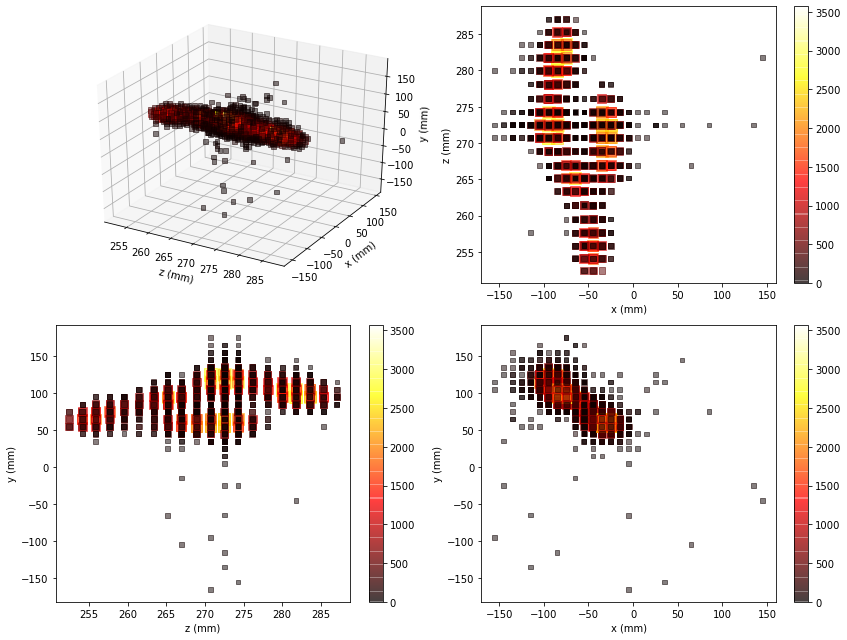

In [43]:
nplay.event(x, y, z, Er, scale = 20, cmap = 'hot')

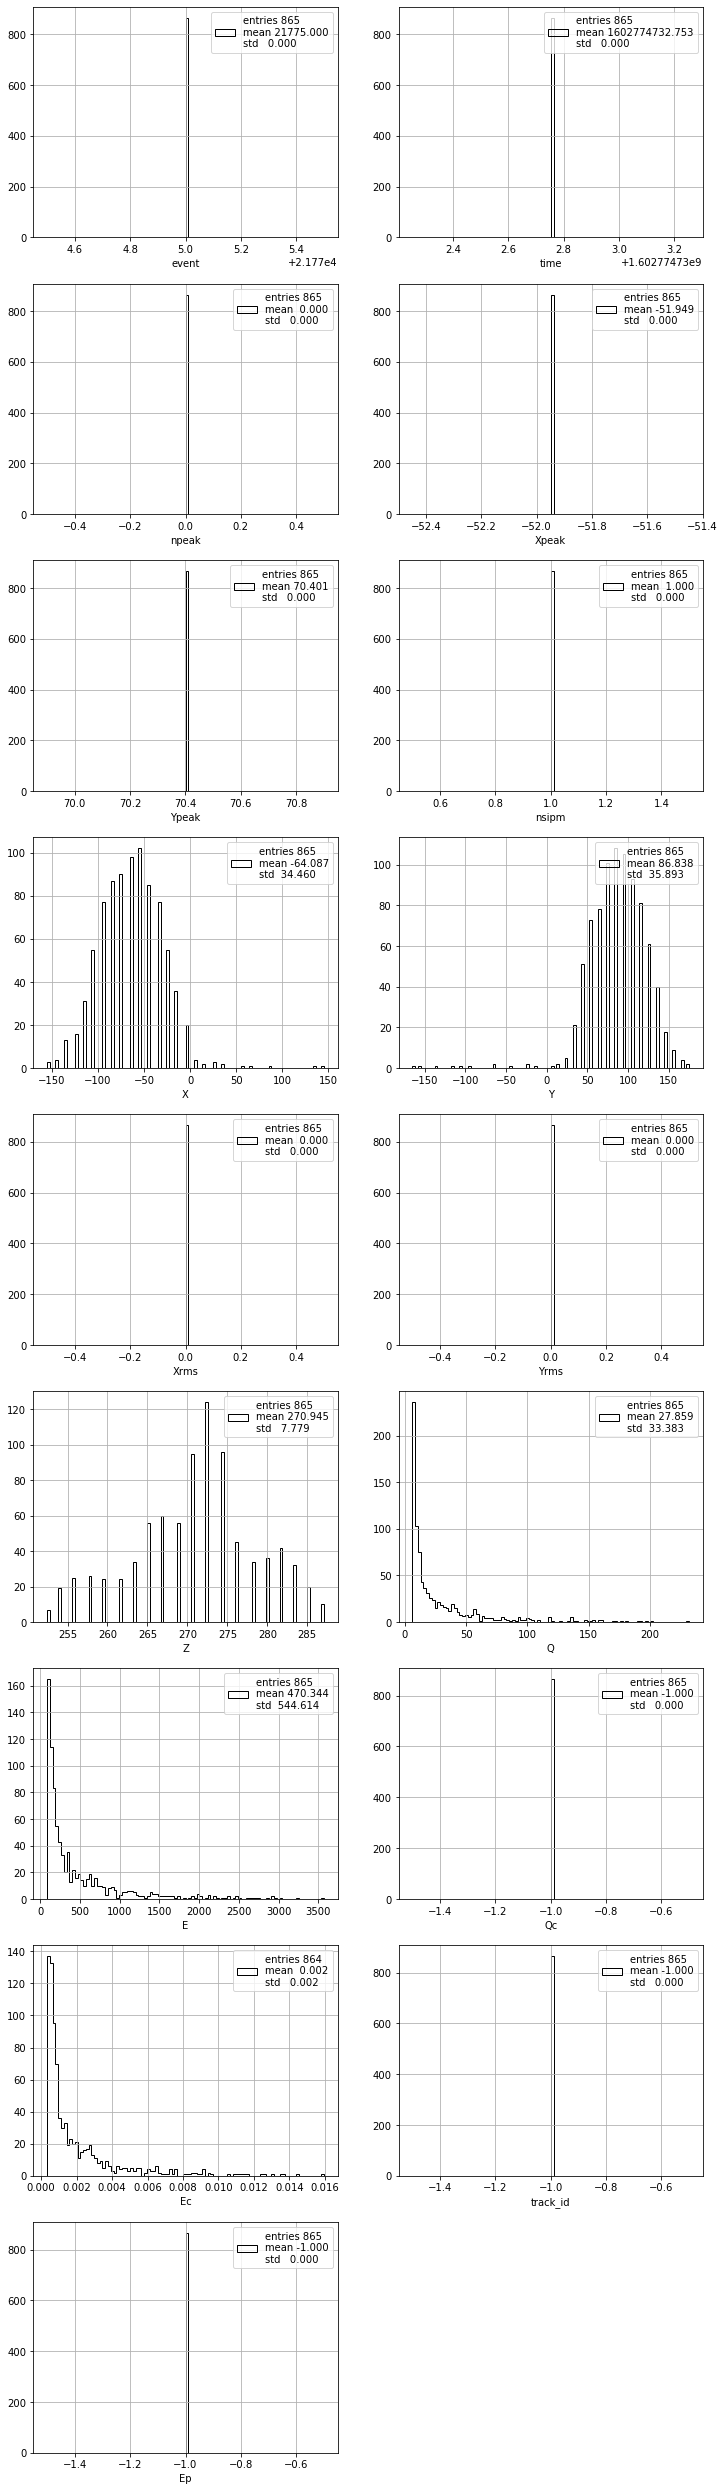

In [44]:
pltext.plt_inspect_df(hh)

## Check nan in E

not a numbers (x, y, z, Ec, E, time) :  [0, 0, 0, 2689, 0, 0]


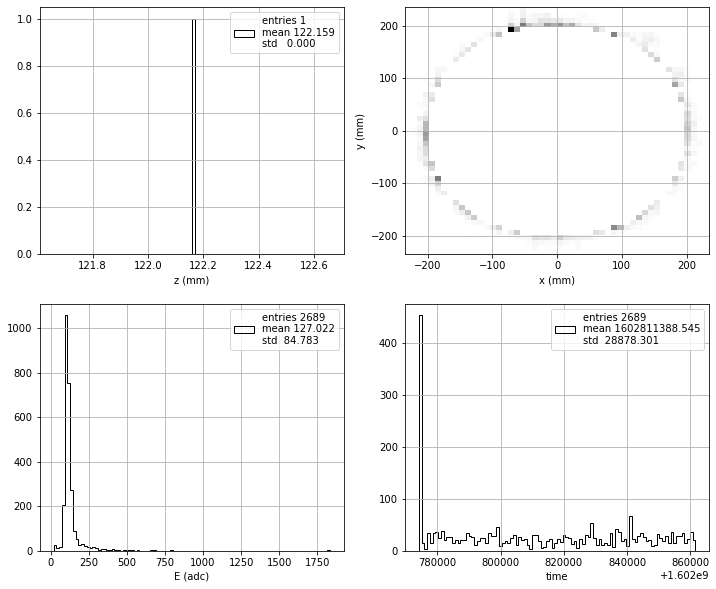

In [87]:
X, Y, Z, Ec, E, t = get_hits(ddh)
xnans = [np.sum(np.isnan(xi)) for xi in [X, Y, X, Ec, E, t]]
print('not a numbers (x, y, z, Ec, E, time) : ', xnans)

xsel = xnans[3] # Ec-nans

subplot = pltext.canvas(4)

subplot(1)
pltext.hist(Z[xsel], 100, xylabels = 'z (mm)');

subplot(2)
xsel = np.isnan(Ec)
plt.hist2d(X[xsel], Y[xsel], (50, 50), cmap = 'Greys');
plt.xlabel('x (mm)'); plt.ylabel('y (mm)'); plt.grid();

subplot(3)
pltext.hist(E[xsel], 100, xylabels = 'E (adc)');

subplot(4)
pltext.hist(t[xsel], 100, xylabels = 'time');


## Check that the E-correction is ok

In [102]:
X, Y, Z, Ec, E, t = get_hits(ddh)
z0 =  23.
ddh['Ec_check'] = E * get_coef(X, Y, Z, t)
ddh['Ec_check_z0shift'] = E * get_coef(X, Y, Z + z0, t)

In [103]:
def plt_check_ec(ddh, label = 'Ec_check'):

    subplot = pltext.canvas(2)
    range_de =  (-0.5, 0.8)

    subplot(1)
    de = 100.*(ddh['Ec']/ddh[label] -1.)
    pltext.hist(de, 100, range = range_de);
    plt.xlabel(r'$\Delta E/E$ hit (%)', fontsize = 12);
    #print(ut.str_stats(de, formate = '8.7f'))

    subplot(2)
    dds = ddh.groupby('event').sum()
    DE = 100.*(dds['Ec']/dds[label] - 1.)
    pltext.hist(DE, 100, range = range_de);
    plt.xlabel(r'$\Delta E/E$ event (%)', fontsize = 12);
    #print(ut.str_stats(DE, formate = '8.7f'))
    return


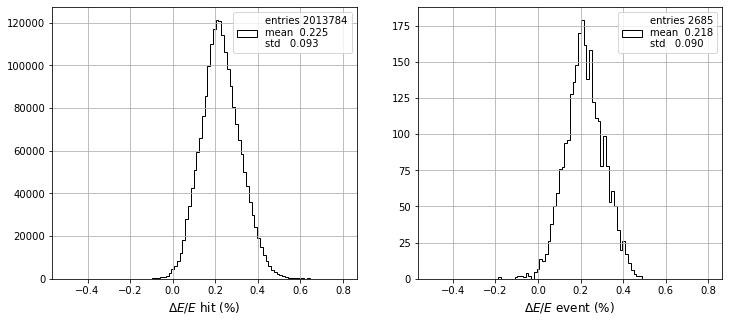

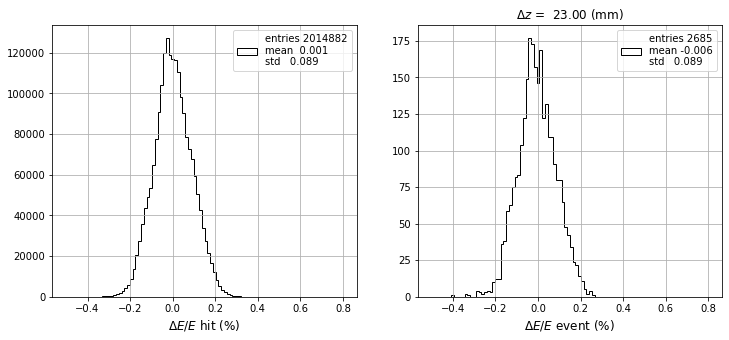

In [145]:
plt_check_ec(ddh)
plt_check_ec(ddh, 'Ec_check_z0shift')
plt.title(r'$\Delta z$ = {:6.2f} (mm)'.format(z0));

In [194]:
def plt_E_ec(ddh, labels = ['Ec', 'Ec_check', 'Ec_check_z0shift']):

    subplot = pltext.canvas(1, 1, 6, 8)
    range_de =  (1.54, 1.78)

    dds = ddh.groupby('event').sum()
    
    hatchs = ['//', '\\', '-']
    subplot(1)
    for i, label in enumerate(labels):
        pltext.hist(dds[label], 80, range = range_de, label = label, alpha = 0.8, lw = 1., fill = 0)  
#                    lw = 1, hatch = hatchs[i]);
    plt.xlabel(r'E event (MeV)', fontsize = 12);
    

    #print(ut.str_stats(de, formate = '8.7f'))

    return

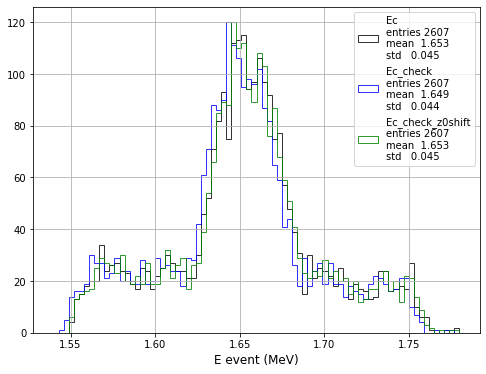

In [195]:
plt_E_ec(ddh)

**Conclusions**

   * Why there is this shift (0.2 %)?

## Still $\Delta$z-effect?

In [205]:
ddmin = ddh.groupby('event').min()
ddmax = ddh.groupby('event').max()
ddave = ddh.groupby('event').mean()
ddsum = ddh.groupby('event').sum()


ddc = {'X'  : ddave['X'] .values, 'Y': ddave['Y'].values, 'Z'  : ddave['Z'].values,
       'Ec' : ddsum['Ec'].values, 'E': ddsum['E'].values, 'DZ' : ddmax['Z'].values - ddmin['Z'].values,
       'Ec_shift' : ddsum['Ec_check_z0shift'].values, 'Ec_check' : ddsum['Ec_check'].values,}

evts = ddmin.index 

ddc = pd.DataFrame(ddc, index = ddmin.index)


In [206]:
ddc

,X,Y,Z,Ec,E,DZ,Ec_shift,Ec_check
event,,,,,,,,
1252,-163.025478,-51.242038,197.318687,0.308552,73242.943499,10.345126,0.308941,0.308084
1253,76.682243,15.000000,283.888601,0.244481,62322.674267,10.556977,0.244562,0.244035
1266,175.410959,5.273973,273.676689,0.334033,67568.026967,12.243688,0.334121,0.333195
1267,-144.652174,-55.347826,146.595043,0.228195,57225.093159,8.592657,0.228585,0.228092
1270,-116.527778,130.138889,185.466800,0.299575,61273.790433,8.632043,0.299972,0.299309
...,...,...,...,...,...,...,...,...
2692490,86.551499,61.753585,395.407688,1.650716,393042.552617,49.374972,1.648034,1.644428
2692627,-76.957447,47.907801,312.108907,1.663268,427988.733543,27.172787,1.661654,1.658076
2693985,68.593131,-134.907530,223.066356,1.681770,392325.501710,93.032456,1.681397,1.677283


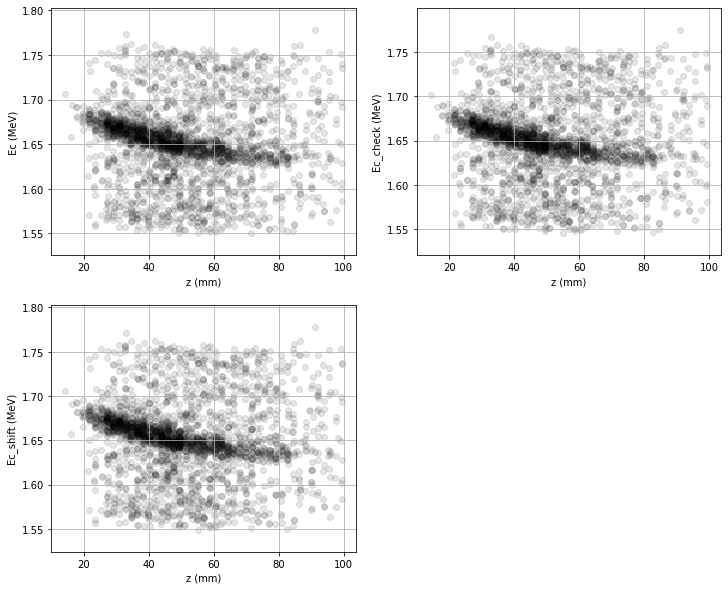

In [211]:
subplot = pltext.canvas(3)

for i, label in enumerate(['Ec', 'Ec_check', 'Ec_shift']):

    subplot(i + 1)
    zsel = (ddc.DZ < 100.) & (ddc[label] > 1.5) & (ddc[label] < 1.78)
    plt.scatter(ddc.DZ[zsel], ddc[zsel][label], alpha = 0.1); plt.grid();
    plt.xlabel('z (mm)'); plt.ylabel(label + ' (MeV)')



**Conclusions:**

  * The $\Delta$z effect is still there